In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=5960d381a26342eeffbc9053617898c6c297b770a60c449f2dec52c097e44f8c
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


Dataset loaded with splits: dict_keys(['train', 'validation', 'test'])
Training examples: 14041
Validation examples: 3250
Test examples: 3453

Sample entry from the dataset:
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

NER Tags: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

First example tokens and their NER tags:
EU - B-ORG
rejects - O
German - B-MISC
call - O
to - O
boycott - O
British - B-MISC
lamb - O
. - O


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.197100,0.054201,0.913506,0.924268,0.918856,0.984424
2,0.040000,0.050777,0.921239,0.940929,0.930980,0.986449
3,0.022300,0.050809,0.930484,0.941602,0.936010,0.987131



Validation Metrics: {'eval_loss': 0.05077655613422394, 'eval_precision': 0.9212390838688417, 'eval_recall': 0.9409289801413665, 'eval_f1': 0.9309799350595287, 'eval_accuracy': 0.9864491258128577, 'eval_runtime': 5.013, 'eval_samples_per_second': 648.32, 'eval_steps_per_second': 40.695, 'epoch': 3.0}

Predictions on custom examples:

Input: Steve Jobs founded Apple in California.
NER Predictions:
steve: B-PER
jobs: I-PER
founded: O
apple: B-ORG
in: O
california: B-LOC
.: O

Input: Microsoft is headquartered in Redmond, Washington and was founded by Bill Gates.
NER Predictions:
microsoft: B-ORG
is: O
headquartered: O
in: O
red: B-LOC
,: O
washington: B-LOC
and: O
was: O
founded: O
by: O
bill: B-PER
gates: I-PER
.: O

Input: The United Nations General Assembly met in New York City last week.
NER Predictions:
the: O
united: B-ORG
nations: I-ORG
general: I-ORG
assembly: I-ORG
met: O
in: O
new: B-LOC
york: I-LOC
city: I-LOC
last: O
week: O
.: O

Model saved to ./ner_model

Visualized Predic

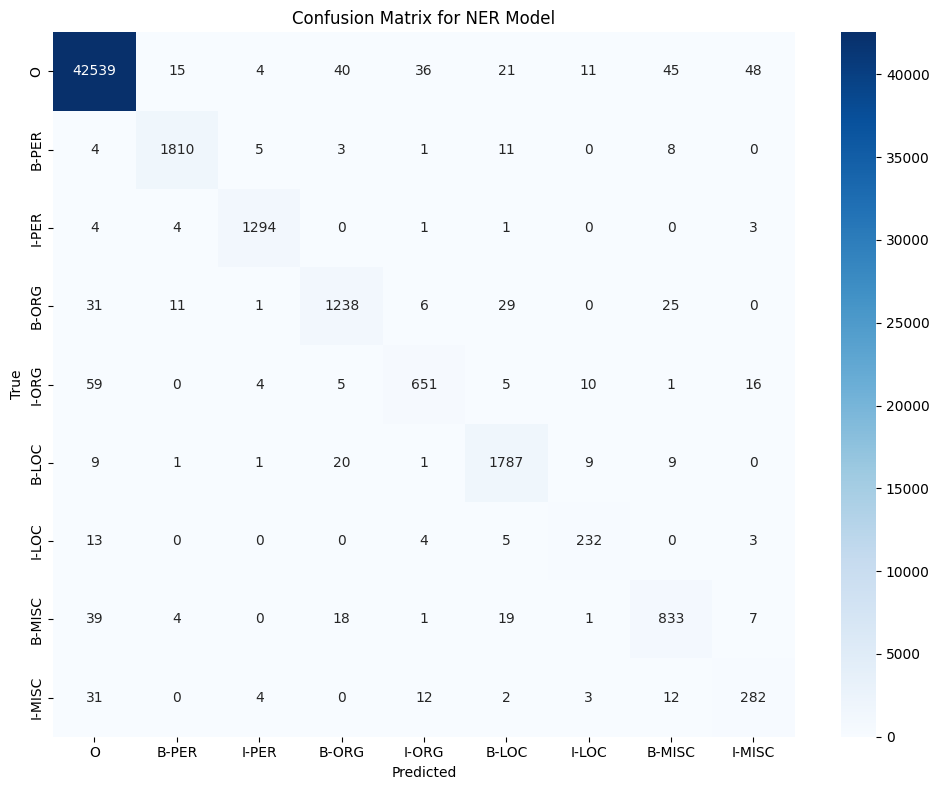

Fine-tuning of the NER model is complete!


In [ ]:
# Named Entity Recognition Fine-tuning with Transformers

import numpy as np
import pandas as pd
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# 1. Load the dataset (CoNLL-2003)
datasets = load_dataset("conll2003")
print(f"Dataset loaded with splits: {datasets.keys()}")
print(f"Training examples: {len(datasets['train'])}")
print(f"Validation examples: {len(datasets['validation'])}")
print(f"Test examples: {len(datasets['test'])}")

# Display a sample from the dataset
print("\nSample entry from the dataset:")
print(datasets["train"][0])

# Get the list of NER tags
label_list = datasets["train"].features["ner_tags"].feature.names
print(f"\nNER Tags: {label_list}")
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

# Display the first few examples
print("\nFirst example tokens and their NER tags:")
for i in range(len(datasets["train"][0]["tokens"])):
    print(f"{datasets['train'][0]['tokens'][i]} - {label_list[datasets['train'][0]['ner_tags'][i]]}")

# 2. Tokenize the inputs
model_checkpoint = "distilbert-base-uncased"  # Smaller model for faster training
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define tokenization function aligning the labels with wordpiece tokens
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to -100 (ignored in loss)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply tokenization to all splits
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

# 3. Fine-tune the model
# Load pre-trained model
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Data collator for proper batching
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define compute_metrics function using seqeval
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Use seqeval for metrics calculation
    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
        "accuracy": accuracy_score(true_labels, true_predictions)
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on validation set
metrics = trainer.evaluate()
print(f"\nValidation Metrics: {metrics}")

# 4. Inference on custom examples
def predict_ner(text):
    # Get the device that the model is on
    device = model.device

    # Tokenize the text
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))
    inputs = tokenizer(text, return_tensors="pt")

    # Store word_ids before moving to device
    word_ids = inputs.word_ids(0)

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label for each token
    predictions = torch.argmax(outputs.logits, dim=2)
    prediction_labels = [label_list[prediction.item()] for prediction in predictions[0]]

    # Align predictions with original tokens
    token_predictions = []
    prev_word_id = None

    for idx, word_id in enumerate(word_ids):
        if word_id is not None and word_id != prev_word_id:
            token_predictions.append((tokens[idx], prediction_labels[idx]))
        prev_word_id = word_id

    return token_predictions

# Test custom examples
custom_examples = [
    "Steve Jobs founded Apple in California.",
    "Microsoft is headquartered in Redmond, Washington and was founded by Bill Gates.",
    "The United Nations General Assembly met in New York City last week."
]

print("\nPredictions on custom examples:")
for example in custom_examples:
    predictions = predict_ner(example)
    print(f"\nInput: {example}")
    print("NER Predictions:")
    for token, label in predictions:
        print(f"{token}: {label}")

# 5. Save the model
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")
print("\nModel saved to ./ner_model")

# 6. Visualize results for one example
def visualize_prediction(text):
    # Get the device that the model is on
    device = model.device

    # Tokenize the text
    tokens = text.split()
    inputs = tokenizer(text, return_tensors="pt")

    # Store word_ids before moving to device
    word_ids = inputs.word_ids(0)

    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label for each token
    predictions = torch.argmax(outputs.logits, dim=2)

    # Get predictions for each token (excluding special tokens)
    token_predictions = []
    for i, word_id in enumerate(word_ids):
        if word_id is not None and (i == 0 or word_id != word_ids[i-1]):
            token_predictions.append(label_list[predictions[0, i].item()])

    # Trim predictions to match original tokens length
    token_predictions = token_predictions[:len(tokens)]

    # Create formatted output for display
    result = []
    for token, pred in zip(tokens, token_predictions):
        if pred != "O":
            entity_type = pred.split('-')[1] if '-' in pred else pred
            result.append(f"[{token}]_{entity_type}")
        else:
            result.append(token)

    return " ".join(result)

# Visualize predictions for a few examples
print("\nVisualized Predictions:")
for example in custom_examples:
    visualization = visualize_prediction(example)
    print(f"Input: {example}")
    print(f"Output: {visualization}")
    print()

# 7. Analyze model performance
# Get validation predictions
validation_results = trainer.predict(tokenized_datasets["validation"])

# Compute confusion matrix
y_true = []
y_pred = []

predictions = np.argmax(validation_results.predictions, axis=2)
labels = validation_results.label_ids

# Filter out ignored indices
for prediction, label in zip(predictions, labels):
    for p, l in zip(prediction, label):
        if l != -100:  # If it's not an ignored index
            y_true.append(l)
            y_pred.append(p)

# Create a confusion matrix (for top classes)
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for NER Model')
plt.tight_layout()
plt.show()

print("Fine-tuning of the NER model is complete!")